# Structure Inside Argon Plated MCM-41 Nanopores

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import colors as colortools
from numpy import pi as π
from scipy.constants import hbar as ħ
from scipy.constants import k as kb
import helium
from pimchelp import PimcResults
from collections import defaultdict

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('notebook')

## Parameters

In [2]:
T = np.array([1.6,4.2]) #K
τ = 0.004 # (1/K)
L = 50 # Å
Ro = 15.51 # Å
Ri = Ro - 3.5 # Å
P0 = helium.pressure_SVP(T)

In [3]:
print(helium.convert_P(P0,'Pa','torr'))

[  5.59922593 744.2882645 ]


## Grab, Process and Load Results

In [4]:
%run /Users/agdelma/Documents/UVM/Projects/SCRIPTS/reduce-one.py -r u -T 1.6 -L 50 -t 0.004 ../../Data/Nanopores/
%run /Users/agdelma/Documents/UVM/Projects/SCRIPTS/reduce-one.py -r u -T 4.2 -L 50 -t 0.004 ../../Data/Nanopores/

### A key for temperature

In [5]:
def Tkey(T):
    return f'T = {T:3.1f} K'

### Chemical Potential vs. Reduced Pressure

In [6]:
x = np.linspace(1E-16,1,1000)

μ_exp = {}
for i,cT in enumerate(T):
    μ_exp[Tkey(cT)] = helium.chemical_potential(x*P0[i],T[i])

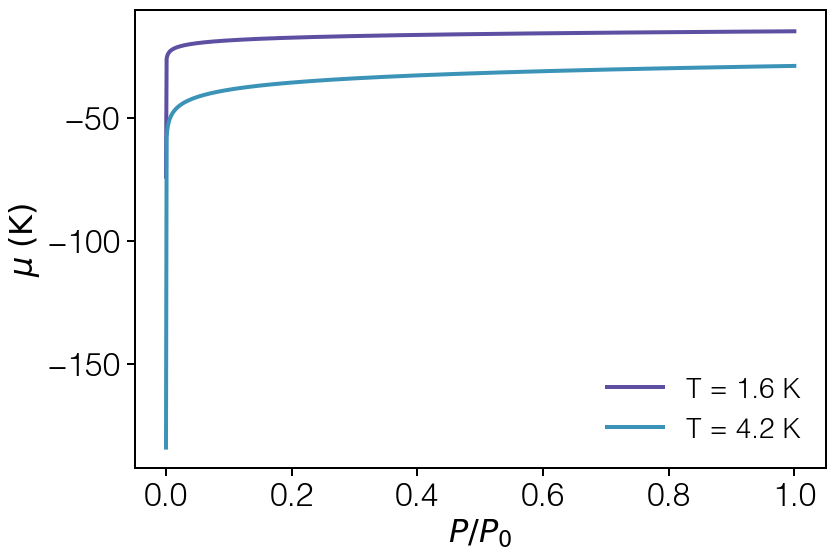

In [7]:
for i,cT in enumerate(T):
    plt.plot(x,μ_exp[Tkey(cT)], label=Tkey(cT))

plt.ylabel(r'$\mu\; (\mathrm{K})$')
plt.xlabel(r'$P/P_0$')
plt.legend()

## Investigate the Filling of the Pore

In [8]:
est = {}
x = {}
for i,cT in enumerate(T):
    est[Tkey(cT)] = PimcResults('../../../Data/Nanopores/estimator-u-reduce-T-{:06.3f}-t-0.00400-L-050.000.dat'.format(cT))
    μ = est[Tkey(cT)].data['u']
    x[Tkey(cT)] = helium.pressure(est[Tkey(cT)].data['u'],cT)/helium.pressure_SVP(cT)

colors = colortools.get_linear_colors('Spectral',len(μ),reverse=False)
Tcolors = {Tkey(T[0]):colors[-10],Tkey(T[1]):colors[10]}

/Users/agdelma/local/miniconda3/lib/python3.7/site-packages/pynverse/inverse.py:196: RuntimeWarning: Results obtained with less than 8 decimal digits of accuracy
  % accuracy, RuntimeWarning)
/Users/agdelma/local/miniconda3/lib/python3.7/site-packages/pynverse/inverse.py:196: RuntimeWarning: Results obtained with less than 8 decimal digits of accuracy
  % accuracy, RuntimeWarning)


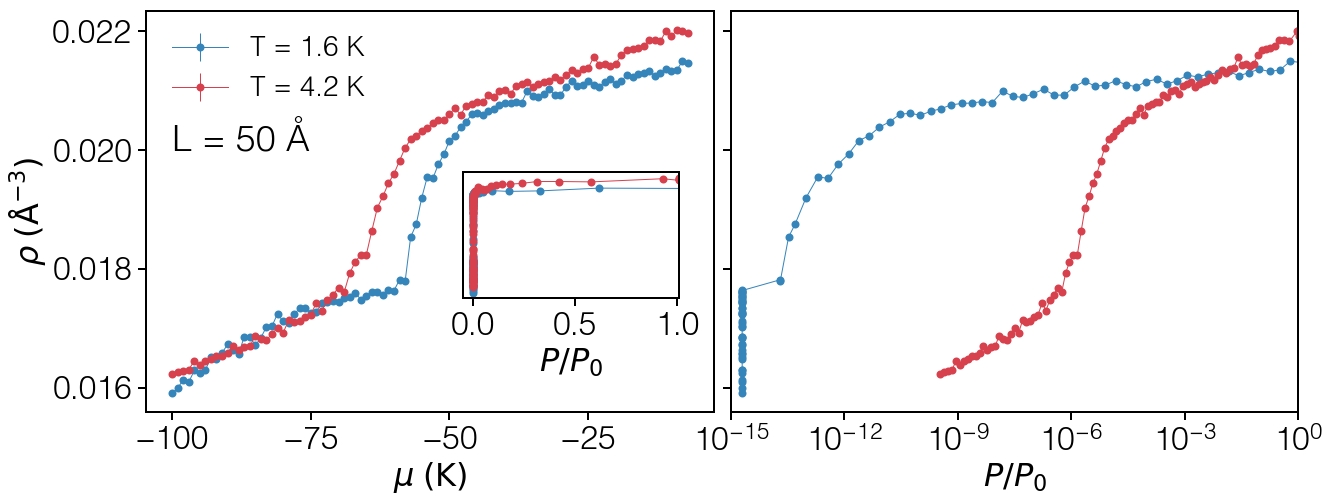

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,2,sharex=False, sharey=True, squeeze=True, figsize=(10,3.5))
fig.subplots_adjust(wspace=0.03)

for i,cT in enumerate(T):
    cest = est[Tkey(cT)]
    axes[0].errorbar(cest.data['u'],cest.data['density'],yerr=cest.data['Δdensity'], 
                     marker='o', color=Tcolors[Tkey(cT)], markersize=3,lw=0.5, label=Tkey(cT))

    axes[1].errorbar(x[Tkey(cT)],cest.data['density'],yerr=cest.data['Δdensity'], color=Tcolors[Tkey(cT)],
                     marker='o', markersize=3,lw=0.5)

# inset
#axins = inset_axes(axes[0], width="35%", height="25%", loc='lower right', borderpad=3)
axins = plt.axes([0.37, .35, .15, .25])
for i,cT in enumerate(T):
    axins.errorbar(x[Tkey(cT)],est[Tkey(cT)].data['density'],yerr=est[Tkey(cT)].data['Δdensity'], 
                   color=Tcolors[Tkey(cT)],marker='o', markersize=3, lw=0.5)

axins.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axins.set_yticks([])
axins.set_xlim(-0.05,1.01)
axins.set_xlabel(r'$P/P_0$')

axes[0].text(-100,0.02,'L = {:d} Å'.format(L),fontsize=18)
axes[0].legend(loc='upper left')
axes[0].set_xlabel(r'$\mu\; (\mathrm{K})$')
axes[0].set_ylabel(r'$\rho\; (\mathrm{\AA}^{-3})$')    
axes[1].set_xscale('log')
axes[1].set_xlim(1E-15,1)
axes[1].set_xlabel(r'$P/P_0$')
plt.savefig('../Output/rho_vs_mu_and_PoP0.png',dpi=300)

## Look at the Radial Density

In [11]:
radρ = {}
for cT in T:
    radρ[Tkey(cT)] = PimcResults('../../../Data/Nanopores/radial-u-reduce-T-{:06.3f}-t-0.00400-L-050.000.dat'.format(cT))

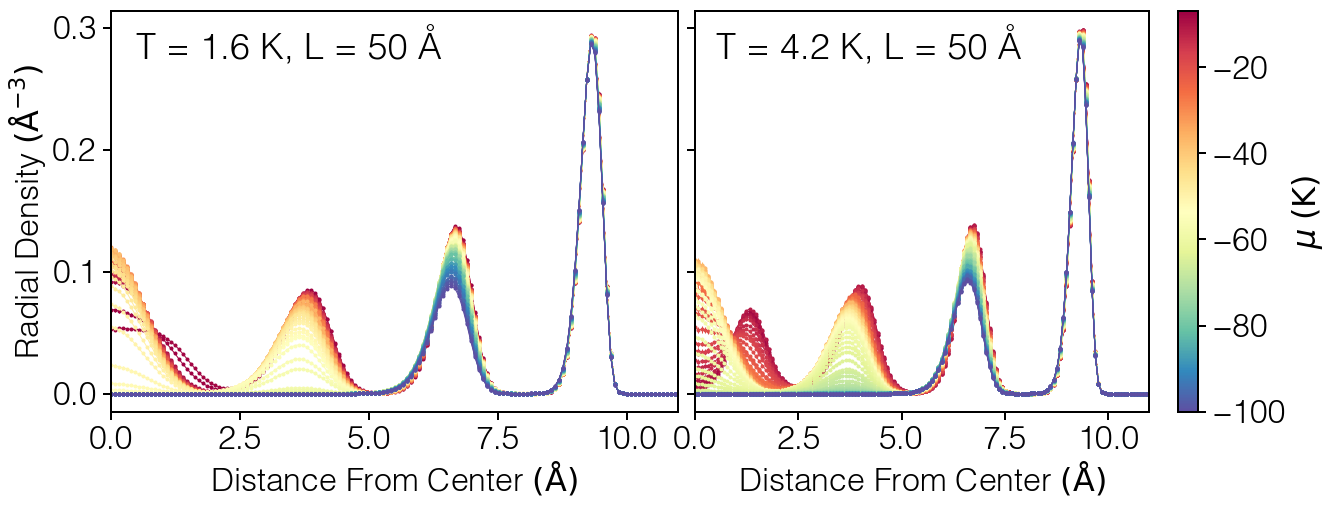

In [13]:
fig, axes = plt.subplots(1,2,sharex=False, sharey=True, squeeze=True, figsize=(10,3.5))
fig.subplots_adjust(wspace=0.03)

for i,cT in enumerate(T):
    for j,param in enumerate(radρ[Tkey(cT)].params):
        axes[i].errorbar(*radρ[Tkey(cT)].epdata(param), marker='o', lw=0.5, ms=1,
                 color=colors[j], label=r'$\mu={:f}$'.format(μ[j]))

    axes[i].text(0.5,0.275,'T = {:3.1f} K, L = {:d} Å'.format(cT,L),fontsize=18)
    axes[i].set_xlabel(r'Distance From Center $(\mathrm{\AA})$')
    axes[i].set_xlim(0,11);
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(2.5))

axes[0].set_ylabel(r'Radial Density $(\mathrm{\AA}^{-3})$')

# create the colorbar
sm = plt.cm.ScalarMappable(cmap=mpl.cm.Spectral_r, norm=plt.Normalize(vmin=μ[0], vmax=μ[-1]))
sm._A = []
plt.colorbar(sm, label=r'$\mu\; (\mathrm{K})$')
plt.savefig('../Output/rho_vs_r.png',dpi=300)

## The Linear Density and Coverage Inside the Pore

In [14]:
from scipy import integrate
from scipy.signal import argrelextrema

In [15]:
ρlin = {} 
coverage = defaultdict(list)
rmin = [2.5,5.0,7.5,12.0]

for cT in T:
    ρlin[Tkey(cT)] = np.zeros([len(μ),3])
    
    for i,param in enumerate(radρ[Tkey(cT)].params):
        # find the location of the first minimum
        r = radρ[Tkey(cT)].x(param)
        ρr = radρ[Tkey(cT)].y(param)
        min_idx = np.where(r>2.5)[0][0] 
        #min_idx = argrelextrema(ρr, np.less)[0][0]
        
        min_r = r[min_idx]
        
        ρlin[Tkey(cT)][i][0] = integrate.simps(r[:min_idx]*ρr[:min_idx],r[:min_idx])*2*π

        min_idx = np.where(r>5.0)[0][0]
        min_r = r[min_idx]
        ρlin[Tkey(cT)][i][1] = integrate.simps(r[:min_idx]*ρr[:min_idx],r[:min_idx])*2*π 

        min_idx = np.where(r>7.5)[0][0]
        min_r = r[min_idx]
        ρlin[Tkey(cT)][i][2] = integrate.simps(r[:min_idx]*ρr[:min_idx],r[:min_idx])*2*π 
        
        if i == 0:
            for j in range(len(rmin)-1):
                min_idx_1 = np.where(r>rmin[j])[0][0] 
                min_idx_2 = np.where(r>rmin[j+1])[0][0] 
                max_idx = argrelextrema(ρr[min_idx_1:min_idx_2], np.greater)[0][-1]
                A = integrate.simps(r[min_idx_1:min_idx_2]*ρr[min_idx_1:min_idx_2],r[min_idx_1:min_idx_2]) / r[min_idx_1+max_idx]
                coverage[Tkey(cT)].append(A)

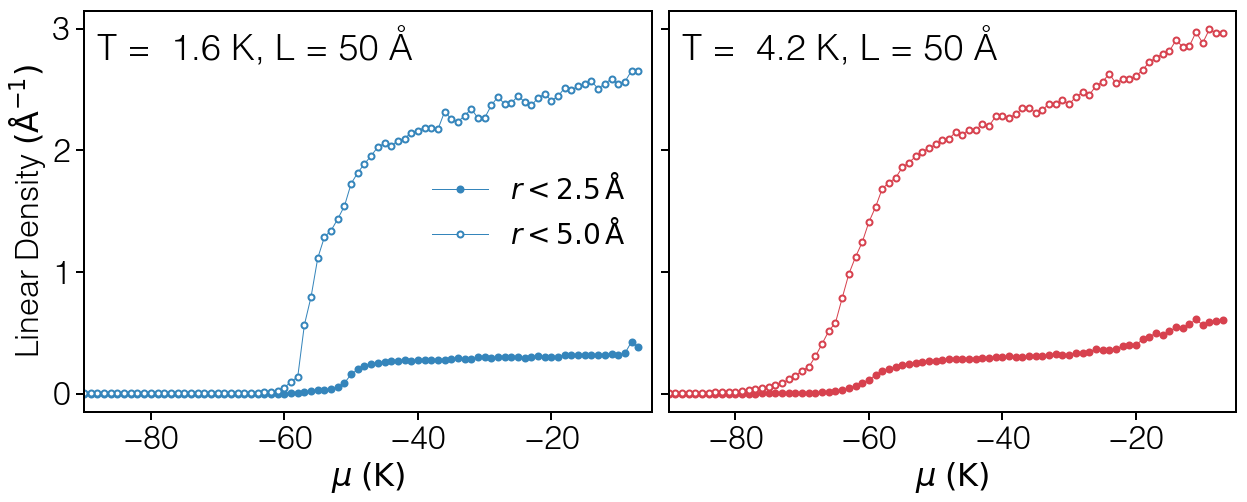

In [16]:
fig, axes = plt.subplots(1,2,sharex=False, sharey=True, squeeze=True, figsize=(10,3.5))
fig.subplots_adjust(wspace=0.03)

for i,cT in enumerate(T):
    axes[i].plot(μ,ρlin[Tkey(cT)][:,0],marker='o', color=Tcolors[Tkey(cT)], markersize=3, lw=0.5, 
                 label=r'$r < 2.5\, \mathrm{\AA}$')
    axes[i].plot(μ,ρlin[Tkey(cT)][:,1],marker='o', color=Tcolors[Tkey(cT)], mfc='w', markersize=3, lw=0.5, label=r'$r < 5.0\, \mathrm{\AA}$')
    
    axes[i].text(-88,2.75,'T = {:4.1f} K, L = {:d} Å'.format(cT,L),fontsize=18)


#plt.plot(μ,ρlin[:,2],marker='o', markersize=3, lw=0.5, label=r'$r < 7.5\, \mathrm{\AA}$')

    axes[i].set_xlim(-90,-5)

    axes[i].set_xlabel(r'$\mu\; (\mathrm{K})$')

axes[0].set_ylabel(r'Linear Density $(\mathrm{\AA}^{-1})$')
axes[0].legend(loc='center right', frameon=False)
plt.savefig('../Output/rholinear_vs_r.png',dpi=300)

## Coverage near the walls

In [17]:
idx = [Tkey(cT) for cT in T]

for j in range(3):
    print('|-')
    print('|{:d}'.format(4-j))
    for i in range(2):
        print('|{:6.4f}'.format(coverage[idx[i]][j]))
print('|}')

|-
|4
|0.0932
|0.0946
|-
|3
|0.1121
|0.1098
|-
|2
|0.1497
|0.1502
|}


## The Wall Potential

In [21]:
data = np.loadtxt('/Users/agdelma/Documents/UVM/Projects/PIMC/OUTPUT/gce-debug-02.000-010.000--011.000-0.04000-421fb4f8-d36a-46b4-95e5-0c38c693a3cb.dat')

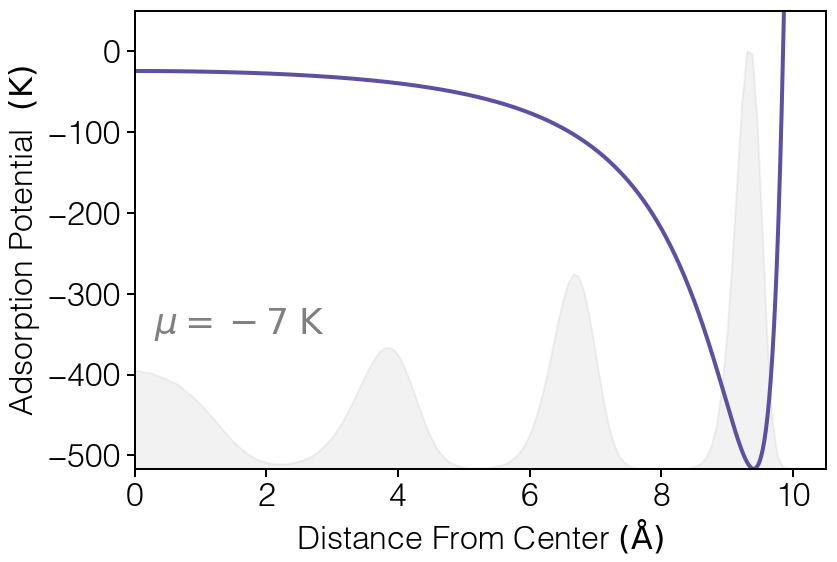

In [25]:
plt.plot(data[:,0],data[:,1])
cdata = -radρ[Tkey(1.6)].y(radρ[Tkey(1.6)].params[0])/np.max(radρ[Tkey(1.6)].y(radρ[Tkey(1.6)].params[0]))*np.min(data[:,1]) + np.min(data[:,1])
plt.fill_between(radρ[Tkey(1.6)].x(radρ[Tkey(1.6)].params[0]),np.min(data[:,1]),cdata, color='gray', alpha=0.1)
plt.xlim(0,10.5)
plt.ylim(np.min(data[:,1]),50)
plt.text(0.3,-350,r'$\mu=-7\; \mathrm{K}$', color='gray', fontsize=18)
plt.xlabel(r'Distance From Center $(\mathrm{\AA})$')
plt.ylabel(r'Adsorption Potential  $(\mathrm{K})$');
plt.savefig('../Output/V_vs_r.png',dpi=300)

## Superfluid Density

In [27]:
ρs = PimcResults('../../../Data/Nanopores/super-u-reduce-T-01.600-t-0.00400-L-050.000.dat')

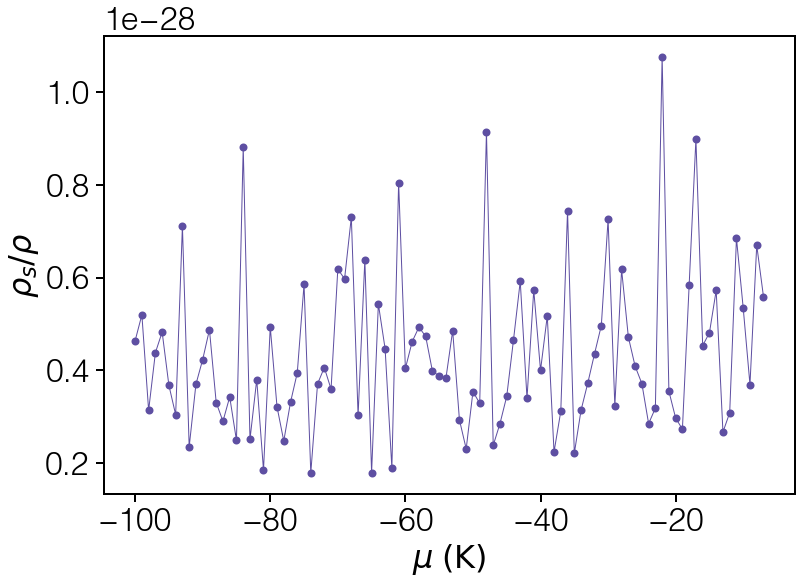

In [28]:
plt.plot(ρs.data['u'],ρs.data['rho_s/rho'],marker='o', markersize=3, lw=0.5)
plt.xlabel(r'$\mu\; (\mathrm{K})$')
plt.ylabel(r'$\rho_s/\rho$');